# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task B](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as not-sexist or one of these four sexist categories: (1) threats, (2)  derogation, (3) animosity, (4) prejudiced discussion.

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Threats

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the five-class classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [1]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `bdatm` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `bdatm`


In [2]:
!pip install torch
!pip install -U bitsandbytes
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

torch.cuda.is_available()

True

In [4]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(0)

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [5]:
def downloadDataFromGitHub(url):
  return  pd.DataFrame(pd.read_csv(url))

url_temp = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2025-2026/Assignment%202/data/'
test_file = 'a2_test.csv'

In [6]:
df_test = downloadDataFromGitHub(url_temp + test_file)
print(f'Test data shape: {df_test.shape} and following is the look at the data')
df_test.head()

Test data shape: (300, 3) and following is the look at the data


,rewire_id,text,label_category
0,sexism2022_english-11647,She may be worth what someone paid for her in ...,derogation
1,sexism2022_english-15883,The men who white knight for women eventually ...,prejudiced
2,sexism2022_english-12494,Two thoughts to keep in mind about women and A...,derogation
3,sexism2022_english-26,"Wimmin. No matter how good they have it, they'...",prejudiced
4,sexism2022_english-7475,"So just a few months ago, while Republican wom...",prejudiced


In [7]:
# check all unique labels
unique_labels = df_test['label_category'].unique()
print(f'Unique labels: {unique_labels}')

Unique labels: ['derogation' 'prejudiced' 'animosity' 'not-sexist' 'threats']


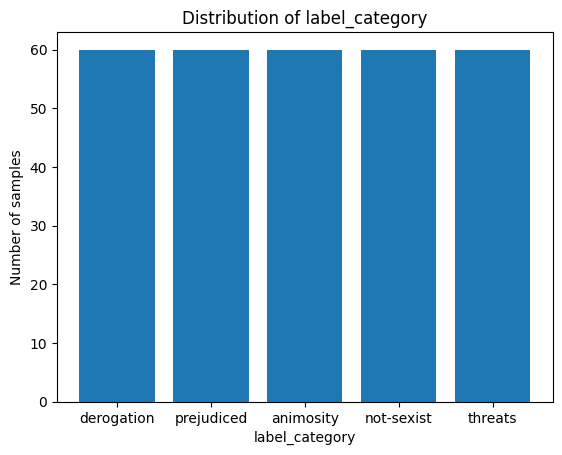

In [8]:
# Distribution bar chart for label_category

label_category = df_test['label_category'].value_counts()
plt.bar(label_category.index, label_category.values)
plt.title('Distribution of label_category')
plt.xlabel('label_category')
plt.ylabel('Number of samples')
plt.show()

In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df_test)
print(dataset)

Dataset({
    features: ['rewire_id', 'text', 'label_category'],
    num_rows: 300
})


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)
- [TinyLlama](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0)
- [DeepSeek-R1](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-7B)
- [Qwen3](https://huggingface.co/Qwen/Qwen3-1.7B)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Note

There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.


In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_cards = ['mistralai/Mistral-7B-Instruct-v0.3', 'TinyLlama/TinyLlama-1.1B-Chat-v1.0']

tokenizers = []
models = []

for model in model_cards:
  print(f'Model: {model}')

  tokenizer = AutoTokenizer.from_pretrained(model, use_fast=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizers.append(tokenizer)

  model = AutoModelForCausalLM.from_pretrained(model, return_dict=True, quantization_config=bnb_config, device_map='auto')

  generation_config = model.generation_config
  generation_config.max_new_tokens = 10
  generation_config.eos_token_id = tokenizer.eos_token_id
  generation_config.pad_token_id = tokenizer.eos_token_id
  generation_config.temperature = 0.1
  generation_config.num_return_sequences = 1
  generation_config.do_sample = False

  models.append(model)

Model: mistralai/Mistral-7B-Instruct-v0.3


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [11]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        TEXT: {text}

        ANSWER:
        """
    }
]

### Checking the tokenizers for both models

In [12]:
mistral_tokenizer = tokenizers[0]
mistral_model = models[0]
prompt_mistral = mistral_tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
print(prompt_mistral)


<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        TEXT: {text}

        ANSWER:
        [/INST]


In [13]:
tl_tokenizer = tokenizers[1]
tl_model = models[1]
prompt_tl = tl_tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
print(prompt_tl)


<|system|>
You are an annotator for sexism detection.</s>
<|user|>
Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        TEXT: {text}

        ANSWER:
        </s>
<|assistant|>



In [14]:
test_data = dataset.select_columns(['text', 'label_category'])
test_data

Dataset({
    features: ['text', 'label_category'],
    num_rows: 300
})

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [75]:
def prepare_prompts(texts, prompt_template, tokenizer, batch_size=8):
    formatted_prompts = []
    tokenized_batches = []

    # format all prompts
    for text in texts:
        prompt_text = prompt_template.replace("{text}", text['text'])
        formatted_prompts.append(prompt_text)

    tokenizer.padding_side = 'left'

    # tokenize in batches
    for i in range(0, len(formatted_prompts), batch_size):
        batch = formatted_prompts[i:i + batch_size]
        tokenized_batch = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512
        )
        tokenized_batches.append(tokenized_batch)

    return tokenized_batches

In [76]:
mistral_prompts_tokenized = prepare_prompts(test_data, prompt_mistral, mistral_tokenizer)
tl_prompts_tokenized = prepare_prompts(test_data, prompt_tl, tl_tokenizer)

print(f"Number of batches: {len(mistral_prompts_tokenized)}")

Number of batches: 38


### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [77]:
def generate_responses(model, prompt_examples, tokenizer, batch_size=8):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate
    a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: A list of pre-processed and tokenized text samples

    Outputs:
      generated responses
  """

  raw_responses = []
  generation_config = model.generation_config
  generation_config.max_new_tokens = 10
  generation_config.eos_token_id = tokenizer.eos_token_id
  generation_config.pad_token_id = tokenizer.eos_token_id
  generation_config.temperature = None
  generation_config.num_return_sequences = 1

  with torch.inference_mode():
    for batch in tqdm(prompt_examples):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        input_len = input_ids.shape[1]

        response = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            do_sample=False,
            use_cache=True
        )

        # raw_response = tokenizer.batch_decode(response[:, input_ids.shape[1]:], skip_special_tokens=True)
        # raw_responses.extend(raw_response)

        # Decode only new tokens (after input_len)
        new_tokens = response[:, input_len:]
        responses = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
        raw_responses.extend(responses)

  return raw_responses

In [78]:
mapping = {
        'not-sexist': 0,
        'threats': 1,
        'derogation': 2,
        'animosity': 3,
        'prejudiced': 4
        }

def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed classification response.
      Use the following mapping:
      {
        'not-sexist': 0,
        'threats': 1,
        'derogation': 2,
        'animosity': 3,
        'prejudiced': 4
      }
  """
  response = response.strip().lower()

  for key in mapping.keys():
      if key in response:
          return mapping[key]

  return -1

In [79]:
mistral_responses = generate_responses(model=mistral_model, prompt_examples=mistral_prompts_tokenized, tokenizer=mistral_tokenizer)

100%|██████████| 38/38 [09:38<00:00, 15.22s/it]


In [80]:
print(mistral_responses[0])
y_mistral_pred = [process_response(r) for r in mistral_responses]

animosity


In [81]:
tl_responses = generate_responses(model=tl_model, prompt_examples=tl_prompts_tokenized, tokenizer=tl_tokenizer)

100%|██████████| 38/38 [02:01<00:00,  3.20s/it]


In [82]:
y_tl_pred = [process_response(r) for r in tl_responses]

## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples on Colab.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

We compute **macro F1-score** and the ratio of failed responses generated by models (**fail-ratio**).

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

In summary, we parse generated responses as follows:
- **0** if 'not-sexist'
- **1** if 'threats'
- **2** if 'derogation'
- **3** if 'animosity'
- **4** if 'prejudiced'
- **0** if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [83]:
import numpy as np
from sklearn.metrics import f1_score

In [122]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(y_pred, y_true):
  """
    This function takes predicted and ground-truth labels and compute
    metrics. In particular, this function compute accuracy and
    fail-ratio metrics. This function internally invokes
    `process_response` to compute metrics.

    Inputs:
      y_pred: parsed LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  fail_ratio = sum([1 for y in y_pred if y == -1]) / len(y_pred)
  y_pred_corrected = [0 if y == -1 else y for y in y_pred]
  f1 = f1_score(y_pred=y_pred_corrected, y_true=y_true, average='macro')
  acc = accuracy_score(y_pred=y_pred_corrected, y_true=y_true)
  precision = precision_score(y_pred=y_pred_corrected, y_true=y_true, average='macro', zero_division=0)
  recall = recall_score(y_pred=y_pred_corrected, y_true=y_true, average='macro', zero_division=0)

  return {'macro_f1': round(f1, 2), 'fail_ratio': round(fail_ratio, 2),'acc': round(acc, 2), 'precision': round(precision, 2), 'recall': round(recall, 2)}


In [123]:
y_true_numeric = [mapping[label] for label in test_data['label_category']]

print(f'The metrics for mistral_model are: {compute_metrics(y_mistral_pred, y_true_numeric)}')
print(f'The metrics for TinyLLMA model are: {compute_metrics(y_tl_pred, y_true_numeric)}')


The metrics for mistral_model are: {'macro_f1': 0.37, 'fail_ratio': 0.0, 'acc': 0.38, 'precision': 0.52, 'recall': 0.38}
The metrics for TinyLLMA model are: {'macro_f1': 0.08, 'fail_ratio': 0.95, 'acc': 0.2, 'precision': 0.09, 'recall': 0.2}


# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [86]:
prompt_example = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: {examples}

        TEXT: {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [87]:
prompt_with_examples = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

         EXAMPLES:
         TEXT: **example 1**
         ANSWER: threats
         TEXT: **example 2**
         ANSWER: not-sexist

         TEXT: {text}

        ANSWER:
        """
    }
]

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Modify ``prepare_prompts`` to support demonstrations.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [88]:
demostration_file = 'demonstrations.csv'
demonstrations = downloadDataFromGitHub(url_temp + demostration_file)
print(f'Test data shape: {demonstrations.shape} and following is the look at the data')
demonstrations.head()

Test data shape: (1000, 6) and following is the look at the data


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-7417,female egg donors are allowed to be uggo as fu...,sexist,derogation,2.1 descriptive attacks,train
1,sexism2022_english-10155,My girlfriend is mentally retarded. Or if you ...,sexist,derogation,2.1 descriptive attacks,test
2,sexism2022_english-15154,Lock her UP!!!!,sexist,threats,1.2 incitement and encouragement of harm,train
3,sexism2022_english-13387,So you want to live in a world where women are...,sexist,animosity,"3.1 casual use of gendered slurs, profanities,...",dev
4,sexism2022_english-2990,"Special episode of Loomy Does Politics, by pop...",sexist,prejudiced,4.2 supporting systemic discrimination against...,train


In [89]:
demos_dataset = Dataset.from_pandas(demonstrations)
demos = demos_dataset.select_columns(['text', 'label_category'])
print(demos)

Dataset({
    features: ['text', 'label_category'],
    num_rows: 1000
})


In [90]:
categories = demonstrations['label_category']
categories = categories.unique()
categories

array(['derogation', 'threats', 'animosity', 'prejudiced', 'not-sexist'],
      dtype=object)

In [91]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: DataFrame wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      list of demonstrations to inject into the prompt template.
  """
  example_strings = []
  for category in categories:
    category_ex = demonstrations[demonstrations['label_category'] == category].sample(frac=1).head(num_per_class)

    for _, row in category_ex.iterrows():
            example_strings.append(
                f"TEXT: {row['text']}\nANSWER: {category}"
            )
  # print(example_strings)
  return example_strings

In [102]:
def prepare_few_shots_prompts(texts, prompt_template, tokenizer, demonstrations, batch_size=8):

    formatted_prompts = []
    tokenized_prompts = []
    tokenized_batches = []

    example_strings = build_few_shot_demonstrations(demonstrations, num_per_class=2)
    demo_block = ""
    if example_strings is not None:
        demo_block = "\n".join(example_strings)

    for text in texts:
      prompt_text = prompt_template.replace("{text}", text['text'])
      if "{examples}" in prompt_text:
        prompt_text = prompt_text.replace("{examples}", demo_block)
      formatted_prompts.append(prompt_text)

      # token_prompt = tokenizer.encode_plus(prompt_text, return_tensors='pt', padding=True,
      #                                      truncation=True, max_length=512)
      # tokenized_prompts.append(token_prompt)

    # for batch processing
    tokenizer.padding_side = 'left'

    for i in range(0, len(formatted_prompts), batch_size):
        batch = formatted_prompts[i:i + batch_size]
        tokenized_batch = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=2048
        )
        tokenized_batches.append(tokenized_batch)

    return tokenized_batches

In [103]:
prompt_ex_mistral = mistral_tokenizer.apply_chat_template(prompt_example, tokenize=False, add_generation_prompt=True)
print(prompt_ex_mistral)

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: {examples}

        TEXT: {text}

        ANSWER:
        [/INST]


In [104]:
prompt_ex_tl = tl_tokenizer.apply_chat_template(prompt_example, tokenize=False, add_generation_prompt=True)
print(prompt_ex_tl)

<|system|>
You are an annotator for sexism detection.</s>
<|user|>
Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES: {examples}

        TEXT: {text}

        ANSWER:
        </s>
<|assistant|>



In [105]:
demos_texts = demos_dataset.select_columns(['text'])

mistral_prompts_few_shots = prepare_few_shots_prompts(test_data, prompt_ex_mistral, mistral_tokenizer, demonstrations)

In [111]:
tl_prompts_few_shots = prepare_few_shots_prompts(test_data, prompt_ex_tl, tl_tokenizer, demonstrations)

## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

## Now Generating with the LLMs

In [112]:
mistral_fs_responses = generate_responses(model=mistral_model, prompt_examples=mistral_prompts_few_shots, tokenizer=mistral_tokenizer)

100%|██████████| 38/38 [24:25<00:00, 38.56s/it]


In [113]:
print(mistral_fs_responses[0])
y_mistral_fs_pred = [process_response(r) for r in mistral_fs_responses]

derogation


In [114]:
tl_fs_responses = generate_responses(model=tl_model, prompt_examples=tl_prompts_few_shots, tokenizer=tl_tokenizer)

100%|██████████| 38/38 [04:42<00:00,  7.44s/it]


In [115]:
y_tl_fs_pred = [process_response(r) for r in tl_fs_responses]

In [125]:
print(f'The metrics for mistral_model are: {compute_metrics(y_mistral_fs_pred, y_true_numeric)}')
print(f'The metrics for TinyLLMA model are: {compute_metrics(y_tl_fs_pred, y_true_numeric)}')


The metrics for mistral_model are: {'macro_f1': 0.45, 'fail_ratio': 0.0, 'acc': 0.46, 'precision': 0.55, 'recall': 0.46}
The metrics for TinyLLMA model are: {'macro_f1': 0.07, 'fail_ratio': 0.21, 'acc': 0.2, 'precision': 0.04, 'recall': 0.2}


# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

In [127]:
from collections import Counter

print("TinyLlama Zero-shot prediction distribution:")
print(Counter(y_tl_pred))

print("\nTinyLlama Few-shot prediction distribution:")
print(Counter(y_tl_fs_pred))

print("\nTrue label distribution:")
print(Counter(y_true_numeric))

print("\n--- Sample TinyLlama responses ---")
for i in range(10):
    print(f"True: {test_data[i]['label_category']}")
    print(f"Response: {tl_responses[i][:100]}...")
    print(f"Parsed: {y_tl_pred[i]}")
    print("---")

TinyLlama Zero-shot prediction distribution:
Counter({-1: 285, 1: 13, 0: 2})

TinyLlama Few-shot prediction distribution:
Counter({0: 236, -1: 64})

True label distribution:
Counter({2: 60, 4: 60, 3: 60, 0: 60, 1: 60})

--- Sample TinyLlama responses ---
True: derogation
Response: Sexist categories definitions:

Thre...
Parsed: -1
---
True: prejudiced
Response: Sexist categories definitions:

Thre...
Parsed: -1
---
True: derogation
Response: Sexist categories definitions:

Thre...
Parsed: -1
---
True: prejudiced
Response: Your input text "Wimmin. No matter...
Parsed: -1
---
True: prejudiced
Response: Input text: So just a few months ago,...
Parsed: -1
---
True: prejudiced
Response: Your input text "I don't understand....
Parsed: -1
---
True: animosity
Response: Sexist categories:
1. Thre...
Parsed: -1
---
True: prejudiced
Response: Sexist category: Threats

...
Parsed: 1
---
True: animosity
Response: Sexist category:
The text expresses...
Parsed: -1
---
True: not-sexist
Response: Your 

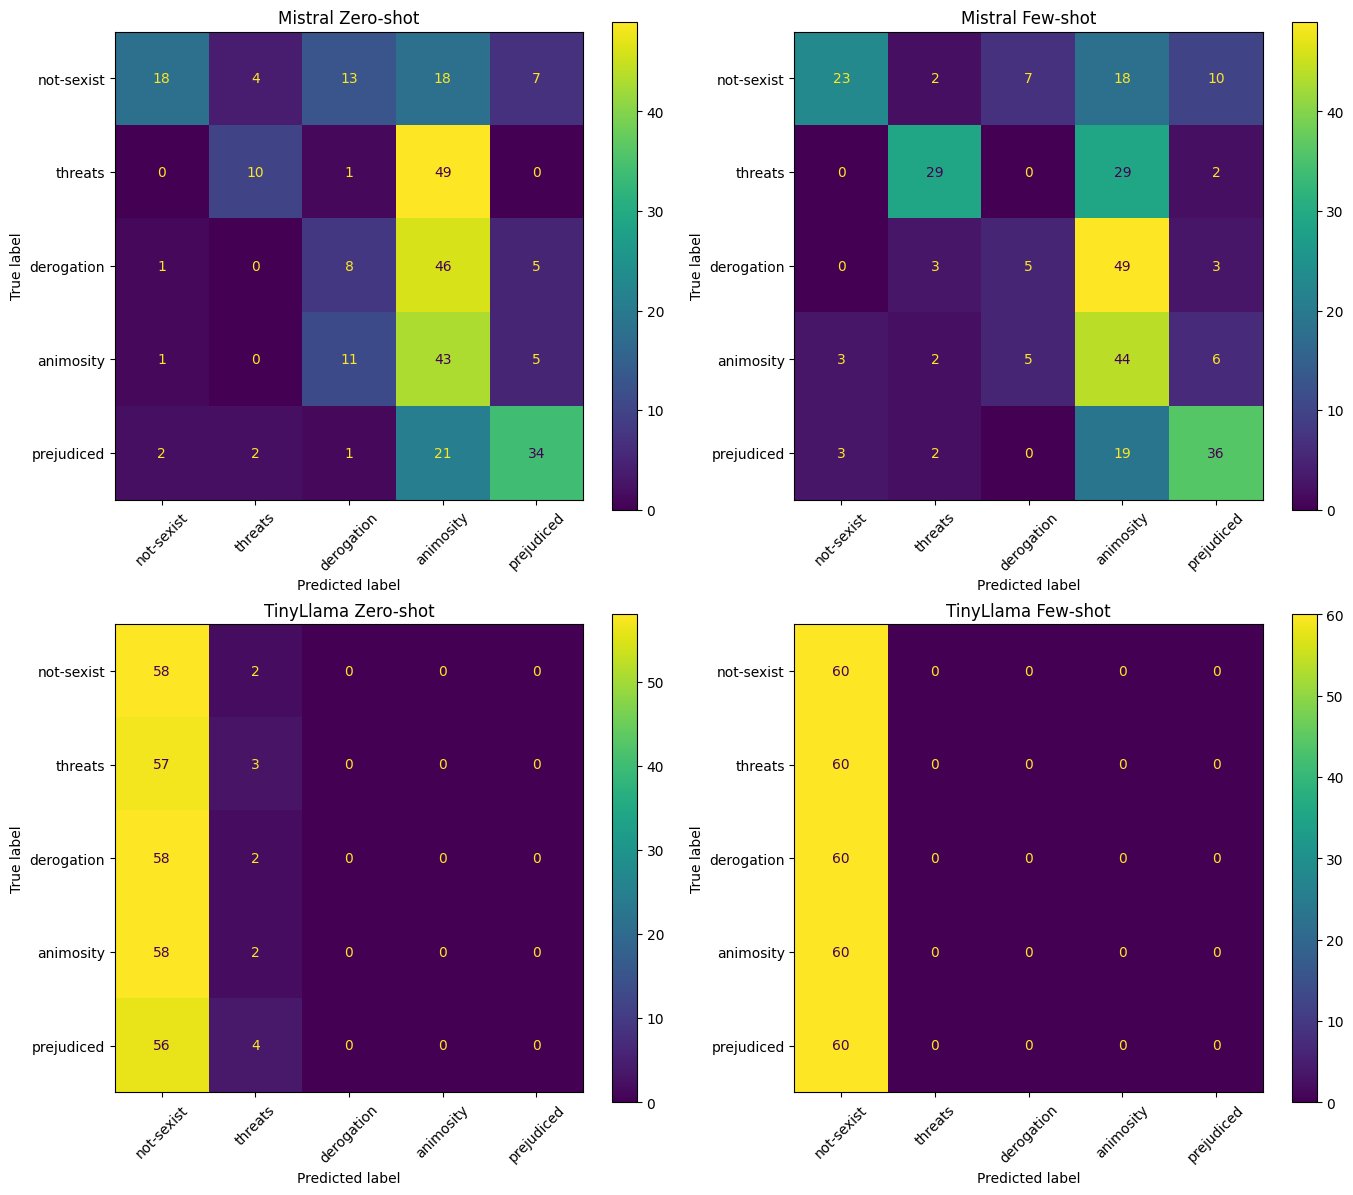

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ['not-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

# Convert -1 to 0 for confusion matrix (same as compute_metrics does)
y_mistral_pred_fixed = [0 if y == -1 else y for y in y_mistral_pred]
y_mistral_fs_pred_fixed = [0 if y == -1 else y for y in y_mistral_fs_pred]
y_tl_pred_fixed = [0 if y == -1 else y for y in y_tl_pred]
y_tl_fs_pred_fixed = [0 if y == -1 else y for y in y_tl_fs_pred]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Mistral Zero-shot
cm = confusion_matrix(y_true_numeric, y_mistral_pred_fixed)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=axes[0,0], xticks_rotation=45)
axes[0,0].set_title('Mistral Zero-shot')

# Mistral Few-shot
cm = confusion_matrix(y_true_numeric, y_mistral_fs_pred_fixed)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=axes[0,1], xticks_rotation=45)
axes[0,1].set_title('Mistral Few-shot')

# TinyLlama Zero-shot
cm = confusion_matrix(y_true_numeric, y_tl_pred_fixed)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=axes[1,0], xticks_rotation=45)
axes[1,0].set_title('TinyLlama Zero-shot')

# TinyLlama Few-shot
cm = confusion_matrix(y_true_numeric, y_tl_fs_pred_fixed)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=axes[1,1], xticks_rotation=45)
axes[1,1].set_title('TinyLlama Few-shot')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

In [129]:
# Check Mistral's per-class accuracy
from sklearn.metrics import classification_report

labels = ['not-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']
print('Zero-shot Mistral')
print(classification_report(y_true_numeric, y_mistral_pred_fixed, target_names=labels))

print(f'\nFew-shot Mistral')
print(classification_report(y_true_numeric, y_mistral_fs_pred_fixed, target_names=labels))

Zero-shot Mistral
              precision    recall  f1-score   support

  not-sexist       0.82      0.30      0.44        60
     threats       0.62      0.17      0.26        60
  derogation       0.24      0.13      0.17        60
   animosity       0.24      0.72      0.36        60
  prejudiced       0.67      0.57      0.61        60

    accuracy                           0.38       300
   macro avg       0.52      0.38      0.37       300
weighted avg       0.52      0.38      0.37       300


Few-shot Mistral
              precision    recall  f1-score   support

  not-sexist       0.79      0.38      0.52        60
     threats       0.76      0.48      0.59        60
  derogation       0.29      0.08      0.13        60
   animosity       0.28      0.73      0.40        60
  prejudiced       0.63      0.60      0.62        60

    accuracy                           0.46       300
   macro avg       0.55      0.46      0.45       300
weighted avg       0.55      0.46      0.

## Results

| Model | Prompting | Macro F1 | Accuracy | Fail Ratio | Inference Time
|-------|-----------|----------|----------|------------|------------|
| Mistral-7B | Zero-shot | 0.37 | 0.38 | 0.00 | ~10 min |
| Mistral-7B | Few-shot | 0.45 | 0.46 | 0.00 | ~24 min |
| TinyLlama-1.1B | Zero-shot | 0.08 | 0.20 | 0.95 | ~2 min |
| TinyLlama-1.1B | Few-shot | 0.07 | 0.20 | 0.21 | ~5 min |




## Our Analysis
Our experiments shows that there is a significant performance gap between Mistral-7B and TinyLlama-1.1B on the sexism detection and labelling.

Mistral achieved 0.45 macro-F1 with few-shot prompting which is an improvement over zero-shot (0.37) and it is consistent with findings that larger models benefit more from in-context learning ([Brown et al., 2020](https://https://arxiv.org/pdf/2005.14165)).

There is semantic similarities between different labels which makes it hard for the model to predict the correct label. Now with zero-shot prompting, Mistral was better at predicting not-sexist and prejudiced and there was an overlap between animosity, derogation and threats. But with few-shot prompting, the score was much better since the models clearly able to differentiate between animosity and threats. Even with few-shot prompting, the Mistral model suffered to differentiate between 'animosty' and 'derogation', defaulting to 'animosity'.

While on the other hand, TinyLlama-1.1B model completely failed in this task because there was a huge parameter difference with Mistral-7B model. With zero-shot prompting, it failed to generate parseable labels in over 95% of the time. With few-shot prompting, the fail-ratio was better but the score was random guessing where it was defaulting to 'not-sexists' in all situations.

Mistral-7B with a few-shot approach was competitive achieving a F1-macro score of 0.45 as compared to [SemEval 2023 EDOS Task B leaderboard](https://https://aclanthology.org/2023.semeval-1.305.pdf) where the best systems achieved ~0.60 with fine-tuning.

These results show that model scale is critical for ambigious and nuanced multi-class classification tasks.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Task Performance

The task is challenging and zero-shot prompting may show relatively low performance depending on the chosen model.

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Evaluate A1 dataset and perform comparison
- Perform prompt tuning

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

# The End